In [1]:
%matplotlib inline
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.get_cmap("viridis")
from tqdm import tqdm

import config
from graph_models import FullGraphModel
from complete_training_data_processing import CompleteModelsDataProcessor
from model_inspection_funcs import neuron_data_from_image, propagate_neuron_data, sample_images

device = torch.device("cpu")
dtype = torch.float32

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
data_processor = CompleteModelsDataProcessor(
    neurons=config.neurons,
    voronoi_criteria=config.voronoi_criteria,
    random_synapses=config.random_synapses,
    log_transform_weights=config.log_transform_weights,
)

model = FullGraphModel(
    input_shape=data_processor.number_of_synapses,
    num_connectome_passes=config.NUM_CONNECTOME_PASSES,
    decision_making_vector=data_processor.decision_making_vector,
    batch_size=config.batch_size,
    dtype=config.dtype,
    edge_weights=data_processor.synaptic_matrix.data,
    device=config.DEVICE,
    num_classes=len(config.CLASSES),
).to(device)

In [3]:
# horrible data stuff
checkpoint = torch.load("models/model_2024-05-20 03:41:43.pth", map_location="cpu")
model.load_state_dict(checkpoint["model"])
model.eval()
connections = (
    pd.read_csv(
        "adult_data/connections.csv",
        dtype={
            "pre_root_id": "string",
            "post_root_id": "string",
            "syn_count": np.int32,
        },
    )
    .groupby(["pre_root_id", "post_root_id"])
    .sum("syn_count")
    .reset_index()
)

connections["weight"] = model.connectome.edge_weight_multiplier.detach()
right_root_ids = data_processor.right_root_ids
all_neurons = (
    pd.read_csv("adult_data/classification_clean.csv")
    .merge(right_root_ids, on="root_id")
    .fillna("Unknown")
)
neuron_data = pd.read_csv(
    "adult_data/right_visual_positions_selected_neurons.csv",
    dtype={"root_id": "string"},
).drop(columns=["x", "y", "z", "PC1", "PC2"])
data_cols = ["x_axis", "y_axis"]
all_coords = pd.read_csv("adult_data/all_coords_clean.csv", dtype={"root_id": "string"})
rational_cell_types = pd.read_csv("adult_data/rational_cell_types.csv")
all_neurons["decision_making"] = np.where(
    all_neurons["cell_type"].isin(rational_cell_types["cell_type"].values.tolist()),
    1,
    0,
)
all_neurons["root_id"] = all_neurons["root_id"].astype("string")

In [4]:
num_passes = 4
base_dir = "images/five_to_fifteen/train"
sub_dirs = ["yellow", "blue"]

sampled_images = sample_images(base_dir, sub_dirs, 100)

dms = {}
for img in tqdm(sampled_images):
    activated_data = neuron_data_from_image(img, neuron_data)
    propagation = propagate_neuron_data(
        activated_data, connections, all_coords, all_neurons, num_passes
    )
    dms[os.path.basename(img)] = propagation["decision_making"][all_neurons["decision_making"] == 1]


100%|██████████| 200/200 [09:21<00:00,  2.81s/it]


In [51]:
data = pd.DataFrame(dms)

In [52]:
means = pd.DataFrame(data.mean(axis=0))
means = means.rename(columns={0: "mean"})
means["yellow"] = [int(a.split("_")[1]) for a in means.index]
means["blue"] = [int(a.split("_")[2]) for a in means.index]
means["color"] = means[["yellow", "blue"]].idxmax(axis=1)

<Axes: xlabel='color', ylabel='mean'>

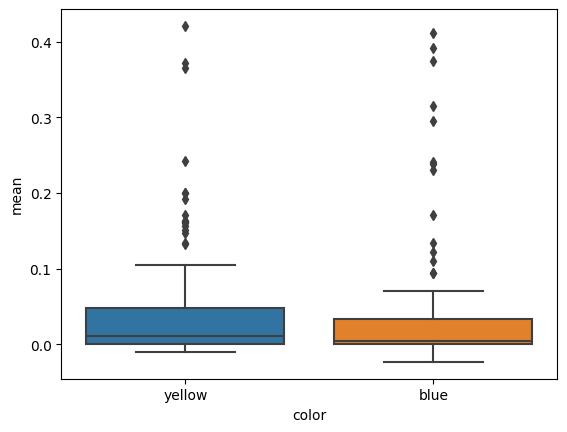

In [53]:
# boxplot of mean depending on color using seaborn
import seaborn as sns

sns.boxplot(x="color", y="mean", data=means)

In [54]:
data[data[data.columns[0]] > 0]

,img_9_6_53_equalized_.png,img_8_6_52_.png,img_9_8_61_.png,img_15_5_191_.png,img_12_10_161_.png,img_15_12_69_equalized_.png,img_12_9_104_equalized_.png,img_6_5_29_.png,img_15_12_13_.png,img_10_9_0_.png,...,img_7_8_128_.png,img_9_10_28_equalized_.png,img_10_12_57_equalized_.png,img_7_14_96_.png,img_12_15_101_.png,img_7_14_179_.png,img_6_9_56_equalized_.png,img_6_8_137_equalized_.png,img_8_10_134_equalized_.png,img_12_15_54_.png
17749,76.857385,1.067327,4.455862,3.428119,27.646597,0.544668,0.785420,0.003037,0.521513,0.412792,...,0.0,53.973792,42.029412,44.060145,2.012301,57.580524,0.022989,0.0,-0.211186,0.787245
25064,78.667475,1.092464,4.560803,3.508856,28.297709,0.557496,0.803917,0.003109,0.533795,0.422514,...,0.0,55.244943,43.019259,45.097818,2.059693,58.936620,0.023531,0.0,-0.216160,0.805786
33945,75.674992,1.050907,4.387312,3.375380,27.221274,0.536289,0.773336,0.002990,0.513490,0.406441,...,0.0,53.143445,41.382821,43.382313,1.981343,56.694691,0.022636,0.0,-0.207937,0.775134
55171,77.595042,1.056448,4.357084,3.363407,27.936493,0.532594,0.791375,0.003073,0.517693,0.415052,...,0.0,54.501663,42.306305,44.520529,1.967692,58.189934,0.023216,0.0,-0.216520,0.793328
120270,76.632166,1.064199,4.442805,3.418074,27.565582,0.543072,0.783118,0.003028,0.519985,0.411582,...,0.0,53.815629,41.906251,43.931033,2.006404,57.411793,0.022922,0.0,-0.210568,0.784938


In [43]:
model.final_fc.weight

Parameter containing:
tensor([[-8.3752],
        [ 7.2369]], requires_grad=True)

In [44]:
model.final_fc.bias

Parameter containing:
tensor([-0.3962, -0.3513], requires_grad=True)